Passo 1: Importando os modulos necessários

In [1]:
import pandas as pd
import datetime
import yfinance as yf
from matplotlib import pyplot as plt
import mplcyberpunk
import smtplib
from email.message import EmailMessage
import os
from dotenv import load_dotenv

Passo 2: Pegar dados no Yahoo Finance

In [2]:
# 1. ATUALIZE O ATIVO DO DÓLAR
ativos = ['^BVSP', 'USDBRL=X'] 

hoje = datetime.datetime.now()
um_ano_atras = hoje - datetime.timedelta(days = 365)

# 2. BAIXA OS DADOS
dados_mercado = yf.download(ativos, um_ano_atras, hoje)

# Exibe o topo do DataFrame (para ver a estrutura)
display(dados_mercado.head())

# 3. APLICA A SOLUÇÃO ANTERIOR (que agora vai funcionar)
# Seleciona a coluna 'Adj Close' para todos os ativos, tratando o MultiIndex
dados_fechamento = dados_mercado.loc[:, 'Close'] 

# Renomeia as colunas
dados_fechamento.columns = ['Ibovespa', 'Dólar'] 
# *Note que a ordem segue a ordem dos ativos na lista: ^BVSP, USDBRL=X*

# Remove as linhas com valores ausentes
dados_fechamento = dados_fechamento.dropna()

display(dados_fechamento.head())

[*********************100%***********************]  2 of 2 completed


Price         Close               High                 Low               Open  \
Ticker     USDBRL=X     ^BVSP USDBRL=X     ^BVSP  USDBRL=X     ^BVSP USDBRL=X   
Date                                                                            
2025-01-09   6.1058  119781.0   6.1590  120145.0  6.054800  119502.0   6.1058   
2025-01-10   6.0346  118856.0   6.1180  120052.0  6.026136  118732.0   6.0346   
2025-01-13   6.1059  119007.0   6.2079  119729.0  6.078800  118743.0   6.1059   
2025-01-14   6.0934  119299.0   6.1376  119451.0  6.042901  118223.0   6.0934   
2025-01-15   6.0548  122650.0   6.1094  122988.0  6.004157  119303.0   6.0548   

Price                  Volume              
Ticker         ^BVSP USDBRL=X       ^BVSP  
Date                                       
2025-01-09  119625.0        0   6611500.0  
2025-01-10  119781.0        0   9255500.0  
2025-01-13  118856.0        0   8161500.0  
2025-01-14  119007.0        0   9349300.0  
2025-01-15  119309.0        0  11928800.0

,Ibovespa,Dólar
Date,,
2025-01-09,6.1058,119781.0
2025-01-10,6.0346,118856.0
2025-01-13,6.1059,119007.0
2025-01-14,6.0934,119299.0
2025-01-15,6.0548,122650.0


Passo 3.1: Manipulando os dados - seleção e exclusão de dados

In [3]:
# Seu código de download anterior...
# ativos = ['^BVSP', 'USDBRL=X'] 
# dados_mercado = yf.download(ativos, um_ano_atras, hoje) 

# --- NOVO BLOCO DE TRATAMENTO ---

# 1. Tenta selecionar a coluna 'Close' (Fechamento), que é mais universal
# Em um MultiIndex, isso seleciona a coluna 'Close' para ambos os tickers.
# Isso retorna um DataFrame 
dados_fechamento = dados_mercado.loc[:, 'Close'] 

# 2. Renomeia as colunas
# A ordem das colunas no DataFrame (como o Pandas as organiza) é:
# Ticker 1, Ticker 2, ...
# Portanto, a ordem dos nomes deve ser: ^BVSP, USDBRL=X
dados_fechamento.columns = ['Ibovespa', 'Dólar'] 

# 3. Remove as linhas com valores ausentes
dados_fechamento = dados_fechamento.dropna()

# Exiba o resultado final
display(dados_fechamento.head())

,Ibovespa,Dólar
Date,,
2025-01-09,6.1058,119781.0
2025-01-10,6.0346,118856.0
2025-01-13,6.1059,119007.0
2025-01-14,6.0934,119299.0
2025-01-15,6.0548,122650.0


Passo 3.2: Manipulando os dados - Criando tabelas com outros timeframes

In [4]:
dados_fechamento_diario = dados_fechamento.copy()
dados_fechamento_mensal = dados_fechamento.resample('ME').last()
dados_fechamento_anual  = dados_fechamento.resample('YE').last()

dados_fechamento_diario

,Ibovespa,Dólar
Date,,
2025-01-09,6.1058,119781.0
2025-01-10,6.0346,118856.0
2025-01-13,6.1059,119007.0
2025-01-14,6.0934,119299.0
2025-01-15,6.0548,122650.0
...,...,...
2026-01-02,5.5170,160539.0
2026-01-05,5.4216,161870.0
2026-01-06,5.4075,163664.0


Passo 4: Calcular fechamento do dia, retorno no ano e retorno no mês dos ativos.

In [5]:
def calcular_retorno(df):
    """
    Calcula retorno percentual sem preenchimento automático de valores ausentes.
    Financeiramente consistente e compatível com versões futuras do pandas.
    """
    return df.pct_change(fill_method=None).dropna()

retorno_no_dia  = calcular_retorno(dados_fechamento_diario)
retorno_no_mes  = calcular_retorno(dados_fechamento_mensal)
retorno_no_ano  = calcular_retorno(dados_fechamento_anual)

retorno_no_dia

,Ibovespa,Dólar
Date,,
2025-01-10,-0.011661,-0.007722
2025-01-13,0.011815,0.001270
2025-01-14,-0.002047,0.002454
2025-01-15,-0.006335,0.028089
2025-01-16,-0.007036,-0.011545
...,...,...
2026-01-02,-0.009355,-0.003637
2026-01-05,-0.017292,0.008291
2026-01-06,-0.002601,0.011083


Passo 5: Localizar o fechamento do dia anterior, retorno no mês e retorno no ano.

In [6]:
retorno_no_dia.loc['2025-10-10']

Ibovespa    0.007872
Dólar      -0.007254
Name: 2025-10-10 00:00:00, dtype: float64

In [7]:
retorno_no_dia.iloc[4, 0]

np.float64(-0.007035765779302872)

In [8]:
retorno_dia_ibov  = retorno_no_dia['Ibovespa'].iloc[-1]
retorno_dia_dolar = retorno_no_dia['Dólar'].iloc[-1]

retorno_mensal_dolar = retorno_no_mes['Dólar'].iloc[-1]
retorno_mensal_ibov = retorno_no_mes['Ibovespa'].iloc[-1]

retorno_anual_dolar = retorno_no_ano['Dólar'].iloc[-1]
retorno_anual_ibov = retorno_no_ano['Ibovespa'].iloc[-1]

retorno_dia_dolar

np.float64(0.005939188146318886)

In [9]:
retorno_dia_dolar = round(retorno_dia_dolar * 100, 2)
retorno_dia_ibov = round(retorno_dia_ibov * 100, 2)

retorno_mensal_dolar = round(retorno_mensal_dolar * 100, 2)
retorno_mensal_ibov = round(retorno_mensal_ibov * 100, 2)

retorno_anual_dolar = round(retorno_anual_dolar * 100, 2)
retorno_anual_ibov = round(retorno_anual_ibov * 100, 2)

retorno_dia_dolar

np.float64(0.59)

Passo 6: Enviar e-mail
https://myaccount.google.com/apppasswords

Condição atingida, gerando relatório!
🎉 SUCESSO! O e-mail foi enviado!


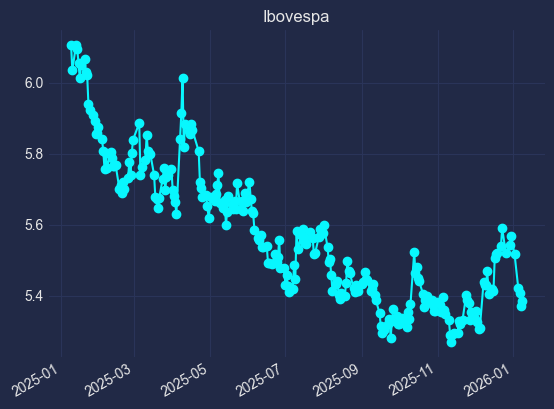

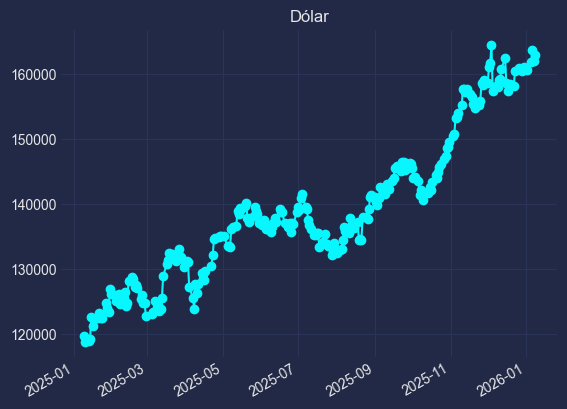

In [ ]:
if retorno_dia_ibov > -1.5:
    print("Condição atingida, gerando relatório!")

    # 1. Gerar os gráficos
    plt.style.use('cyberpunk')

    dados_fechamento.plot(y = 'Ibovespa', use_index = True, marker='o', legend = False)

    plt.title('Ibovespa')
    plt.xlabel('')
    plt.savefig('ibovespa.png', dpi = 300)

    dados_fechamento.plot(y = 'Dólar', use_index = True, marker='o', legend = False)

    plt.title('Dólar')
    plt.xlabel('')
    plt.savefig('dolar.png', dpi = 300)
        
    # 2. Carregar variáveis (APENAS UMA VEZ)
    load_dotenv()
    email_remetente = os.environ.get('EMAIL_USER').strip()
    senha_app = os.environ.get('EMAIL_PASS').strip()
    email_destinatario = os.environ.get('EMAIL_TO').strip()

    # 3. Configurar a Mensagem
    msg = EmailMessage()
    msg['Subject'] = 'Relatório Diário de Mercado – Ibovespa e Dólar'
    msg['From'] = email_remetente
    msg['To'] = email_destinatario

    msg.set_content(f"""
        Prezado(a),

        Segue o relatório diário de mercado, gerado automaticamente via Python.

        📈 Ibovespa
        • Retorno no ano: {retorno_anual_ibov}%
        • Retorno no mês: {retorno_mensal_ibov}%
        • Retorno no último pregão: {retorno_dia_ibov}%

        💵 Dólar (USD/BRL)
        • Retorno no ano: {retorno_anual_dolar}%
        • Retorno no mês: {retorno_mensal_dolar}%
        • Retorno no último pregão: {retorno_dia_dolar}%

        Em anexo, gráficos de desempenho dos ativos.

        Atenciosamente,
        Relatório automatizado via Python
    """)

    # 4. Anexos (Com os nomes corrigidos que você já fez)
    with open('dolar.png', 'rb') as f:
        msg.add_attachment(f.read(), maintype='application', subtype='png', filename='dolar.png')
    
    with open('ibovespa.png', 'rb') as f:
        msg.add_attachment(f.read(), maintype='application', subtype='png', filename='ibovespa.png')

    # 5. Envio (APENAS UM BLOCO)
    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
            smtp.login(email_remetente, senha_app)
            smtp.send_message(msg)
            print("🎉 SUCESSO! O e-mail foi enviado!")
    except Exception as e:
        print(f"Erro ao enviar: {e}")

else:
    print(f"O fechamento ({retorno_dia_ibov}%) não atingiu o limite de alerta.")